<a href="https://colab.research.google.com/github/johnleraas/AB-Testing-Frequentist-vs-Bayesian/blob/main/Bayesian_ABTesting_MCMCSampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

__Author:__ John Leraas

__Date:__ 2/16/2022

__Purpose:__ This notebook was created to provide insight into and examples of Bayesian AB testing.

# Bayesian A/B Testing

This notebook assumes prior knowledge regarding A/B testing and experimental design. 

While the "Frequentist Approach" is most often applied to A/B Testing, the Bayesian approach provides several significant advantages:
* Answers the Question Being Asked: "What is the probability that the conversion rate B is better than the conversion rate of A?"
* Fewer Observations are typically needed in order to provide meaningful results
* Uncertainty in parameter estimates is easily expressed with Bayesian analysis
* The experiment can be optimized for a given metric (e.g. revenue, clicks, etc.) throughout the course of the experiment (i.e. Multi-Armed Bandit)

In Bayesian A/B testing we are seeking to estimate the posterior probability distribution for our parameters (e.g. conversion rate of A, conversion rate of B, difference in conversion rate, lift).

### Bayes' Theorem
Bayes' Theorem (applied to model parameters and the corresponding data) states:

$$
P(\theta|X) = \frac{P(X|\theta) P(\theta)} {P(X)}
$$

where

> $\theta = $ the parameters for the underlying distribution

> $X = $ the observed outcome (data)

We generally refer to the components as:

> $P(\theta|X)$: the __Posterior Distribution__

> $P(X|\theta)$: the __Likelihood__

> $P(\theta)$: the __Prior Probability Distribution__

> $P(X)$: the __Evidence__, a normalizing constant (probabilities should sum to 1)


### Solving For and Estimating Posterior Probability Distribution
In the case of A/B testing it turns out that we can neatly solve for the posterior probability distribution using conjugate priors (more detail below). There are many examples of situations in which solutions for the posterior are intractible or not practical to solve (in closed form or numerically). In these situations we can approximate solutions through (1) sampling or (2) variational inference. Sampling is practical in lower dimensional situations (such as this), and requires no assumptions about the model family.


### Bayesian Approach
* __Select a Likelihood Function:__ For binary outcomes (e.g. click or don't click), and specifically Bernoulli Random Trials, a Binomial Distribution is appropriate.
* __Select a Prior Function:__ The specific A/B testing problem makes the Beta Distribution a particularly good choice.
* __Apply Belief in Model Parameters Through Prior:__ If there is a strong (or weak) belief derived from pre-existing knowledge or insight, this can be incorporated in the prior. Additionally, a uniform prior can be used to convey no pre-existing insight or expectation regarding the prior.
* __Collect All Observations:__ Run the experiment
* __Calculate Posterior Probobalities:__ Calculate the probability distribution of the parameter, representing the conversion rate in this case, of both A and B.
* __Compare Results:__ Calculate the probability that B is better than A. Interestingly, the conversion rate of A and B are represented by distributions so this can be solved via an integration of the probability distributions.

# Import Libraries

In [ ]:
import numpy as np
import pymc3 as pm
import math
from scipy.special import betaln
from scipy import stats
import arviz as az

import seaborn as sns
import matplotlib.pyplot as plt

# Data Setup

In [ ]:
# Create Data
mean_A = .25  #True Mean of A
mean_B = .3  #True Mean of B
n = 1000  #Number of Observations in Experiment
sample = int(n/2) #Number of observations from A and B separately

# Create Datasets - Binomial Distribution
data_A=np.random.binomial(n=1, p=mean_A, size=sample)
data_B=np.random.binomial(n=1, p=mean_B, size=sample)

# Solution 1 - Conjugate Priors

## Posterior Distribution
Again, we are most interested in finding the posterior distribution of our parameter(s). Given our likelihood function (Binomial Distribution) and prior distribution (Beta Distribution) we are presented with a special case in which we can apply __conjugate priors__ to obtain a closed form solution for the posterior distribution. In this case the posterior distribution is of the same form as the prior.

Referencing the closed form solution (https://en.wikipedia.org/wiki/Conjugate_prior):

$$
P(\theta|X) = Beta(X|\alpha', \beta')
$$
where $\alpha'$ and $\beta'$ include information from the prior and experiment:

$$
\alpha' = \alpha + S
$$$$
\beta' = \beta + F
$$

We will use this posterior distribution form in analyzing the results of the A/B test.

In [ ]:
# Define linespace
line_parts = 1000
x = np.linspace(0, 1, num=line_parts)


### Data A

# Define alpha', beta' - Successes, Failures, Uninformative Prior
S = sum(data_A)
F = data_A.shape[0] - S
alpha_A = 1 + S
beta_A = 1 + F

# Calculate Posterior Distribution
posterior_A = stats.beta.pdf(x, a=alpha_A, b=beta_A)/sum(stats.beta.pdf(x, a=alpha_A, b=beta_A))


### Data B

# Define alpha', beta' - Successes, Failures, Uninformative Prior
S = sum(data_B)
F = data_B.shape[0] - S
alpha_B = 1 + S
beta_B = 1 + F

# Calculate Posterior Distribution
posterior_B = stats.beta.pdf(x, a=alpha_B, b=beta_B)/sum(stats.beta.pdf(x, a=alpha_B, b=beta_B))

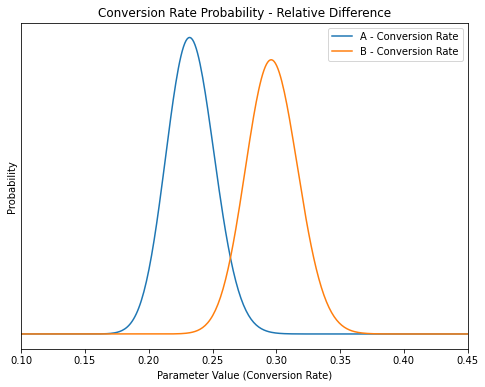

In [ ]:
# Plot
plt.figure(figsize = (8, 6))
plt.plot(x, posterior_A)
plt.plot(x, posterior_B)
plt.xlim(mean_A-.15, mean_B+.15)
plt.xlabel('Parameter Value (Conversion Rate)')
plt.ylabel('Probability')
plt.yticks(ticks=None, labels=None)
plt.yticks([])
plt.title('Conversion Rate Probability - Relative Difference')
plt.legend(['A - Conversion Rate', 'B - Conversion Rate'])
plt.show()

To find the probability that the conversion rate of B is greater than that of A (by any amount) we evaluate the joint probability distribution. Note that for this metric we would integrate from mean_A = 0 to mean_A = mean_B across all mean_A (i.e. all values where mean_B > mean_A).

In [ ]:
def prob_B_better (alpha_A, beta_A, alpha_B, beta_B):
    total = 0
    for i in range(0, alpha_B): # Note add one to alpha_B - 1 for full range
        total += math.exp(
            betaln(alpha_A+i, beta_B+beta_A) -\
            math.log(beta_B + i) -\
            betaln(1+i, beta_B) -\
            betaln(alpha_A, beta_A)
        )
    return total

prob = prob_B_better (alpha_A, beta_A, alpha_B, beta_B)
print("Probability B is better than A: {:.2f}".format(prob*100))

Probability B is better than A: 98.91


# Solution 2 - MCMC NUTS Sampling

In Bayesian A/B Testing we are simply attempting to calculate or approximate the probability of the model parameter (probability of conversion) given the data, the posterior distribution.

$$
P(\theta|X) = \frac{P(X|\theta) P(\theta)} {P(X)}
$$

However, the posterior distribution (or the expected value) is often intractable to compute. This can be due to the complexity of the posterior distribution, high dimensionality of the parameter space, or require integrations without closed form solutions.

Sampling methods can provide good parameter estimates and are appropriate for lower dimension problems. In this case we will apply MCMC NUTS as a sampling method (Markov Chain Monte Carlo No U-Turn Sampling).

While I will not detail the sampling method, however, at a high level:
* Rejection Sampling - If you were to draw the posterior distribution for the conversion rate of A on a piece of paper, tape it to the wall, throw 10,000 darts at the paper, cut out the actual distribution (throw away all observations above the line - not that in practice these are thrown out at each step), and then bin and count the number of dart hits for each bin this should provide a good representation of the distribution. For example, the most probable point is the highest (physically), so we would expect the most darts to hit in this area. This is an example of a grid search approach to rejection sampling. While straightforward, this is an ineffecient method which is of particular concern (i) in high dimensionality situations, where you would be sampling significant amounts of empty space, and (ii) when the posterior is numerically challenging to calculate (for the rejection decision).
* MCMC NUTS Sampling - This is one alternative to performing a grid search and can be thought of as a smart way to explore the boundary of a mountain in X,Y,Z space, where Z is the rejection boundary. MCMC NUTS sampling results in more time spent near the top of the mountain (higher probability region). Additionaly resources provide more detailed descriptions:

> https://www.youtube.com/watch?v=XV4yj4T4PBQ

> https://www.youtube.com/watch?v=yApmR-c_hKU

The basic steps are:

1. Pick values for the parameters from the prior distributions

2. Compute the likelihood for these parameters

3. Use this likehood in Bayes' Theorem to compute posteriors for the parameters and compute the next point using MCMC sampling.

## Sampling - Estimating Metrics

In addition to simply estimating the conversion rate of A and the conversion rate of B through sampling, we can also define custom metrics. We will specifically sample:


*   **Conversion Rate of A**
*   **Conversion Rate of B**
*   **Difference**: Conv Rate B - Conv Rate A
*   **Lift**: (Conv Rate B - Conv Rate A) / Conv Rate A



In [ ]:
with pm.Model():
  #Prior
  samp_A = pm.Beta('A_mean', alpha=1, beta=1)
  samp_B = pm.Beta('B_mean', alpha=1, beta=1)

  #Likelihood
  A_obs = pm.Bernoulli('A_obs', samp_A, observed=data_A)
  B_obs = pm.Bernoulli('B_obs', samp_B, observed=data_B)

  #Include Other Metrics
  pm.Deterministic('Difference', samp_B - samp_A)
  pm.Deterministic('Lift', (samp_B - samp_A)/samp_B)

  #Sample
  trace = pm.sample(return_inferencedata=True, progressbar=True, draws=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [B_mean, A_mean]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 11 seconds.


## Display Technical Results
We can use the ArviZ library to quickly summarize the results for a technical audience:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f230585a790>,
      dtype=object)

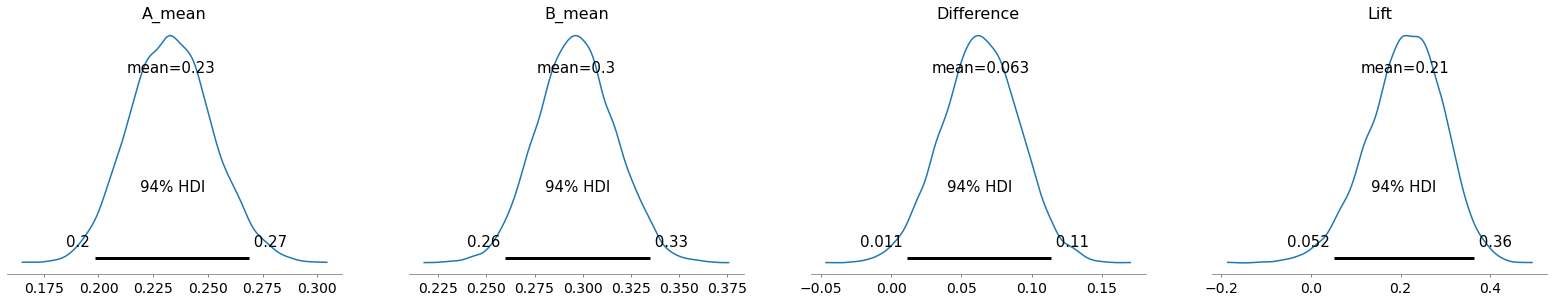

In [ ]:
# Plot Posterior Distributions
az.plot_posterior(trace)

In [ ]:
# Summary
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A_mean,0.233,0.019,0.198,0.269,0.000,0.000,9196.0,6754.0,1.0
B_mean,0.296,0.020,0.260,0.335,0.000,0.000,9237.0,7164.0,1.0
Difference,0.063,0.027,0.011,0.114,0.000,0.000,8935.0,6376.0,1.0
Lift,0.210,0.084,0.052,0.363,0.001,0.001,8732.0,6787.0,1.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f230c29b750>],
      dtype=object)

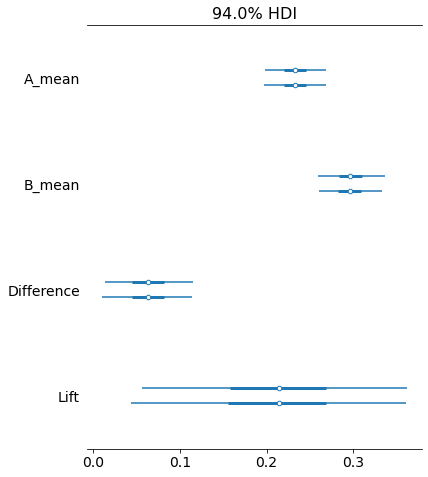

In [ ]:
# High Density Intervals
az.plot_forest(trace)

## Display Currated Results
We can also tailor the results to a less technical audience and to more specifically answer the 'business questions' being asked.

In [ ]:
A_mean_samples = trace.posterior['A_mean'].values[0]
B_mean_samples = trace.posterior['B_mean'].values[0]
diff_samples = trace.posterior['Difference'].values[0]
lift_samples = trace.posterior['Lift'].values[0]

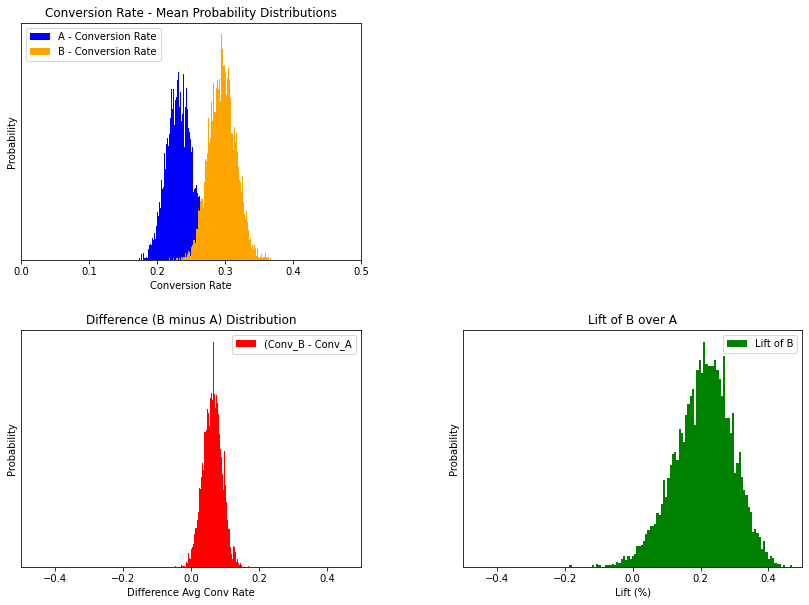

In [ ]:
fig = plt.figure(figsize=(14,10))

ax1 = fig.add_subplot(221)
ax1.hist(A_mean_samples, bins=100, density=False, color='b')
ax1.hist(B_mean_samples, bins=100, density=False, color='orange')
plt.xlim(0, 0.5)
plt.xlabel('Conversion Rate')
plt.ylabel('Probability')
plt.title('Conversion Rate - Mean Probability Distributions')
plt.legend(['A - Conversion Rate', 'B - Conversion Rate'])
plt.yticks([])

ax4 = fig.add_subplot(223)
#ax2.hist(A_mean_samples, bins=50, density=False, color='b', alpha=0)
#ax2.hist(B_mean_samples, bins=50, density=False, color='orange', alpha=0)
ax4.hist(diff_samples, bins=100, density=False, color='r', alpha=1)
plt.xlim(-.5, 0.5)
plt.xlabel('Difference Avg Conv Rate')
plt.ylabel('Probability')
plt.title('Difference (B minus A) Distribution')
plt.legend(['(Conv_B - Conv_A'])
plt.yticks([])

ax3 = fig.add_subplot(224)
#ax2.hist(A_mean_samples, bins=50, density=False, color='b', alpha=0)
#ax2.hist(B_mean_samples, bins=50, density=False, color='orange', alpha=0)
ax3.hist(lift_samples, bins=100, density=False, color='g', alpha=1)
plt.xlim(-0.5, 0.5)
plt.xlabel('Lift (%)')
plt.ylabel('Probability')
plt.title('Lift of B over A')
plt.legend(['Lift of B'])
plt.yticks([])

plt.subplots_adjust(wspace = 0.3, hspace=0.3)

plt.show()

In [ ]:
# There is an X% chance Conv Rate B > Conv Rate A
(diff_samples>0).sum()/len(diff_samples)

0.9832

In [ ]:
# Lift 10% or more
(lift_samples>.1).sum()/len(lift_samples)

0.8654

## Summary Results

### Experimental Results

In [ ]:
print('Probability Conv Rate B is > Conv Rate A%: {:.2%}'.format((diff_samples>0).sum()/len(diff_samples)))
print('')
print('Probability that Lift is at least 10%: {:.2%}'.format((lift_samples>.1).sum()/len(lift_samples)))
print('Probability that Lift is at least 15%: {:.2%}'.format((lift_samples>.15).sum()/len(lift_samples)))
print('Probability that Lift is at least 20%: {:.2%}'.format((lift_samples>.20).sum()/len(lift_samples)))



Experimental Results

Probability Conv Rate B is > Conv Rate A%: 98.98%

Probability that Lift is at least 10%: 89.74%
Probability that Lift is at least 15%: 76.50%
Probability that Lift is at least 20%: 57.02%



# Actual Values

In [ ]:
print('Conversion Rate of A: {:.2%}'.format(mean_A))
print('Conversion Rate of B: {:.2%}'.format(mean_B))
print("")
print('Actual Lift of B over A: {:.2%}'.format((mean_B - mean_A) / mean_A))


Conversion Rate of A: 25.00%
Conversion Rate of B: 30.00%

Actual Lift of B over A: 20.00%
